# 라이브러리 불러오기

In [1]:
#필요한 library 들을 load 합니다.
import os 
from glob import glob
os.environ["CUDA_VISIBLE_DEVICES"]="0" 

import numpy as np
import pandas as pd
from tqdm import tqdm
from multiprocessing import cpu_count
import matplotlib.pyplot as plt
import seaborn as sns

# Image handling
from torchvision import datasets, transforms
from PIL import Image

# Pytorch
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, RandomSampler, SequentialSampler, ConcatDataset
from torchvision import models
from vit_pytorch import ViT


# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder

# Augmenting library 
import albumentations as A
import torchvision.transforms as T

# Control Randomness
import random
random_seed = 7
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

import warnings
warnings.filterwarnings("ignore")

RGB 채널별로 평균과 표준편차를 구해줍니다.

데이터 정규화를 시켜주는 이유는 간단히 다음과 같습니다.

1. 평균을 0, 분산을 1로 만들어줌으로써 학습 속도를 증가

2. Train/Val 과 Test 데이터의 분포가 다름(Dataset Shift Problem)으로써 나오는 악영향을 줄임

등등, https://hyen4110.tistory.com/20

In [2]:
temp_transform = T.Compose([
    T.ToTensor(), #이미지 데이터를 tensor 데이터 포멧으로 바꾸어줍니다.
    # T.Resize([224, 224]), #이미지의 크기가 다를 수 있으니 크기를 통일해 줍니다.
    # T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)) #픽셀 단위 데이터를 정규화 시켜줍니다.
])

# R_mean = data[0][:, 0].mean().numpy()
# G_mean = data[0][:, 1].mean().numpy()
# B_mean = data[0][:, 2].mean().numpy()

# R_std = data[0][:, 0].std().numpy()
# G_std = data[0][:, 1].std().numpy()
# B_std = data[0][:, 2].std().numpy()

R_mean = 0.4912
G_mean = 0.4820
B_mean = 0.4465

R_std = 0.2457
G_std = 0.2429
B_std = 0.2610

Pytorch는 String 형태의 레이블을 입력받지 못하므로, 숫자형태로 매핑해줍니다.

In [3]:
submission = pd.read_csv('./data/sample_submission.csv')
train_imgs = glob('./data/train/*/*')
train_labels = [path.split('\\')[1] for path in train_imgs]
test_imgs = glob('./data/test/*')

# Pytorch는 String 형태의 label을 입력받지 못합니다.
label_map = {
    'airplane' : 0, 
    'automobile': 1, 
    'bird': 2,
    'cat': 3, 
    'deer': 4, 
    'dog': 5, 
    'frog': 6,
    'horse': 7, 
    'ship': 8, 
    'truck': 9,
}

# Dataset 정의

In [4]:
class train_dataset(Dataset):
    def __init__(self, imgs, labels, transform = None):
        super(train_dataset, self).__init__()
        self.imgs = imgs
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        assert len(self.imgs) == len(self.labels)
        return len(self.imgs)
    
    def __getitem__(self, idx):
        X = np.array(Image.open(self.imgs[idx]))
        y = label_map[self.labels[idx]]
        
        if self.transform:
            img = self.transform(image = X)['image']
        else:
            img = X
    
        y = torch.tensor(y, dtype = torch.long)
        return {
            'img' : img,
            'label' : y
        }
    
class test_dataset(Dataset):
    def __init__(self, imgs, transform = None):
        super(test_dataset, self).__init__()
        self.imgs = imgs
        self.transform = transform
        # self.n_tta = n_tta
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        X = np.array(Image.open(self.imgs[idx]))
        if self.transform:
            img = self.transform(image = X)['image']
            return img
        else:
            return X

# Config

하이퍼파라미터들을 설정해 줍니다.

batch_size 란 하드웨어에 한번에 load 할 데이터의 크기입니다. 

num_workers 란 데이터 로드 멀티 프로세싱을 위한 파라미터입니다. Windows에서는 따로 설정하면 에러납니다.

Train 데이터 batch_size는 적당한 값, val/test 데이터는 하드웨어가 감당하는 최대한 큰 값으로 하면 좋습니다.

In [5]:
re_size = 64
patch_size = 4

projection_dim = 64     # 1024, 512
num_heads = 4
transformer_layers = 8

train_batch_size = 64
valid_batch_size = 128
test_batch_size = 128

epochs = 100
learning_rate = 1e-3
weight_decay = 1e-3

save_name = f'js_vit_r{re_size}p{patch_size}_b{train_batch_size}_lr{learning_rate}_e{epochs}'
save_path = f'models/{save_name}.pt'

print(save_name)
print(save_path)

js_vit_r64p4_b64_lr0.001_e100
models/js_vit_r64p4_b64_lr0.001_e100.pt


# 데이터 증강 (Augmentation)

데이터 형태마다 고유의 증강 기법이 존재합니다. 

증강을 통해 Train 데이터에 변형을 주어 다양성(Variability)를 높이고, Bias를 낮춰 앞서 말한 Dataset shift 문제에 대처할 수 있습니다.

즉, 과적합(Overfitting)에 조금 더 강건한 모델을 만들 수 있습니다.

이미지에는 다음과 같은 증강 기법들이 존재합니다. 컴퓨터 비전 관련한 수업을 들으신 분들은 익숙하실 것입니다.
1. 픽셀 단위 증강 : 가우시안 블러링, 가우시안 노이즈 추가, 픽셀 정규화, Grayscaling 등
2. 공간 수준 증강(Spatial-level Augmentation): Resize, Crop, Rotate, Flip, Shift 등 

- 이외에도 Cutout, Mixup, CutMix, Augmix 등 다양한 증강 기법들이 개발되고 있습니다.

**Validation 및 Test 데이터에는 Augmentation을 적용하면 안 됩니다. (정규화 제외)**
- Test-time Augmentation(TTA)라는 기법이 있긴 하지만, 여기서는 적용하지 않겠습니다.

In [6]:
from albumentations.pytorch import ToTensorV2
import cv2

train_transform = A.Compose([
    A.Resize(re_size, re_size, interpolation=cv2.INTER_AREA),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.GaussNoise(p=0.3),
    A.OneOf([
        A.MotionBlur(blur_limit = 3, p = 1.0),
        A.MedianBlur(blur_limit = 3, p = 1.0),
        A.Blur(blur_limit = 3, p = 1.0),
        ], p = 0.3),
    A.ShiftScaleRotate(rotate_limit = 30),
    A.OneOf([
        A.OpticalDistortion(p = 1.0),
        A.GridDistortion(p = 1.0),
        ], p = 0.3),
    A.OneOf([
        A.CLAHE(clip_limit = 2),
        A.RandomBrightnessContrast(),
        ], p = 0.3),
    A.HueSaturationValue(p = 0.3),
    A.Normalize(mean=(R_mean, G_mean, B_mean), std=(R_std, G_std, B_std)),
    ToTensorV2(),
])

else_transform = A.Compose([
    A.Resize(re_size, re_size, interpolation=cv2.INTER_AREA),
    A.Normalize(mean=(R_mean, G_mean, B_mean), std=(R_std, G_std, B_std)),
    ToTensorV2(),
])

In [7]:
len(test_imgs)

10000

Train/Val split

In [8]:
train_data = datasets.ImageFolder(root='./data/train/',transform=temp_transform)
train_imgs = glob('./data/train/*/*')
train_labels = [path.split('\\')[1] for path in train_imgs]
test_imgs = glob('./data/test/*')

# Pytorch는 String 형태의 label을 입력받지 못합니다.
label_map = {
    'airplane' : 0, 
    'automobile': 1, 
    'bird': 2,
    'cat': 3, 
    'deer': 4, 
    'dog': 5, 
    'frog': 6,
    'horse': 7, 
    'ship': 8, 
    'truck': 9,
}

train_imgs, val_imgs, train_labels, val_labels = train_test_split(train_imgs, train_labels, test_size = 0.2,
                                                                  stratify = train_labels, random_state = 42)
len(train_imgs), len(val_imgs), len(train_labels), len(val_labels)

(40000, 10000, 40000, 10000)

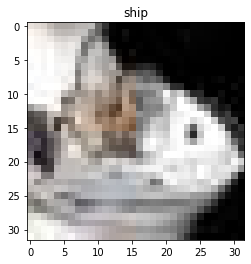

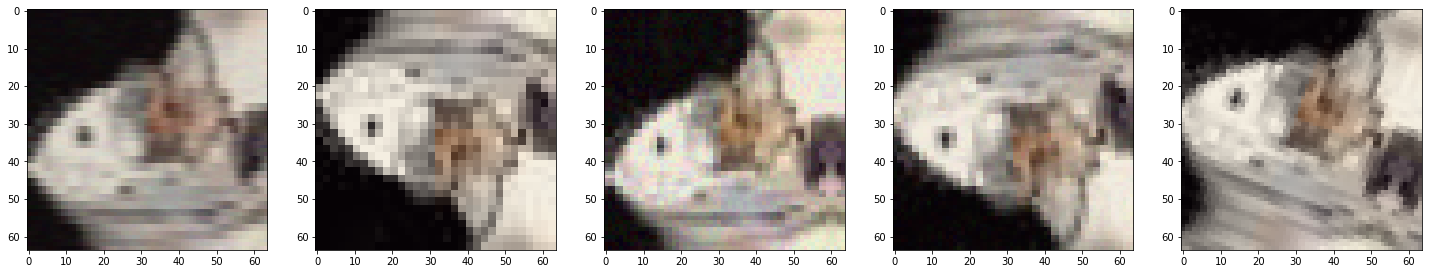

In [9]:
def display_aug(imgs, transform, labels = None, n_aug = 5, cols = 5):
    idx = random.randint(0, len(imgs) - 1)
    
    plt.imshow(np.array(Image.open(imgs[idx])))
    
    if labels:
        label = labels[idx]
        plt.title(label)
    plt.show()
    
    rows = int(np.ceil(n_aug / cols))
    
    fig, axes = plt.subplots(rows, cols, figsize = (cols * 5, rows * 5))

    for i in range(n_aug):
        img = np.array(Image.open(imgs[idx]))
        img = transform(image = img)['image']
        img = np.clip(img.numpy().transpose(1, 2, 0) * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]), 0, 1)
        axes.flat[i].imshow(img)
    plt.show()

display_aug(train_imgs, train_transform, labels = train_labels)

data loader 를 생성해줍니다. 

data loader 란 데이터 셋을 순회하며 모델에 데이터를 넣어주는 객체입니다. 

In [10]:
train_loader = DataLoader(train_dataset(train_imgs, train_labels, transform = train_transform),
                          shuffle = True, batch_size = train_batch_size)
val_loader = DataLoader(train_dataset(val_imgs, val_labels, transform = else_transform),
                        shuffle = False, batch_size = valid_batch_size)

In [11]:
next(iter(train_loader))['img'].shape, next(iter(train_loader))['label']

# (B, C, H, W), (B, num_classes)

(torch.Size([64, 3, 64, 64]),
 tensor([1, 4, 9, 3, 4, 8, 7, 7, 4, 2, 2, 3, 8, 9, 9, 6, 7, 9, 0, 9, 3, 0, 4, 9,
         5, 8, 7, 3, 9, 0, 5, 5, 5, 1, 8, 3, 4, 3, 5, 3, 4, 4, 8, 4, 2, 2, 7, 3,
         9, 5, 0, 8, 3, 6, 9, 7, 8, 4, 3, 8, 2, 7, 1, 5]))

device 를 설정해줍니다.

이번 베이스라인에서는 gpu 가 있다고 가정하겠습니다. 

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.cuda.is_available()

True

# Model

전이학습을 위한 모델을 load 해줍니다. 

PYTORCH 의 models 메소드를 사용하면 손쉽게 외부의 모델을 불러올 수 있습니다.

이번 베이스라인에서는 efficientnet_b3 모델을 사용해 볼 것입니다. 

사전 학습 모델을 사용하는 것은 부정행위에 해당하니, pretrained 파라미터를 False 로 설정해야 합니다!

pretrained 파라미터를 True 로 설정한다면, ImageNet 이라는 데이터셋을 대상으로 학습된 모델이 load 됩니다.

반면, pretrained 파라미터를 False 로 설정한다면, 모델의 구조만 load 되고 모델의 가중치 들은 load 되지 않습니다. 

In [13]:
model = ViT (
    image_size = re_size,
    patch_size = patch_size,
    num_classes = 10,
    dim = projection_dim,
    depth = 6,
    heads = 16,
    mlp_dim = projection_dim*2,
    dropout = 0.1,
    emb_dropout = 0.1
)

In [14]:
model

ViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=4, p2=4)
    (1): Linear(in_features=48, out_features=64, bias=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (transformer): Transformer(
    (layers): ModuleList(
      (0): ModuleList(
        (0): PreNorm(
          (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (fn): Attention(
            (attend): Softmax(dim=-1)
            (to_qkv): Linear(in_features=64, out_features=3072, bias=False)
            (to_out): Sequential(
              (0): Linear(in_features=1024, out_features=64, bias=True)
              (1): Dropout(p=0.1, inplace=False)
            )
          )
        )
        (1): PreNorm(
          (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (fn): FeedForward(
            (net): Sequential(
              (0): Linear(in_features=64, out_features=128, bias=True)
              (1): GELU()
              (2): Dropou

In [15]:
sample_img = next(iter(train_loader))['img']
sample_lab = next(iter(train_loader))['label']
model(sample_img)[0], sample_lab[0]

(tensor([ 0.0333, -0.4473,  0.8003,  0.3682,  0.5094,  0.2658, -0.0092, -0.4444,
          0.8260,  0.2667], grad_fn=<SelectBackward0>),
 tensor(6))

In [16]:
criterion = nn.CrossEntropyLoss(reduction='sum')
optimizer = optim.AdamW(params=model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# 학습 

train/validate 함수를 따로 정의해주었습니다.

In [17]:
from sklearn.metrics import f1_score 
import gc

def train(model, loader, epoch, nb_epochs):
    print(f'Epoch {epoch+1}/{nb_epochs}')
    running_loss = 0.0
    # running_f1 = 0.0
    running_corrects = 0
    model.train()
    # scaler = torch.cuda.amp.GradScaler()
    # y_true = []
    # y_pred = []

    for idx, batch in enumerate(tqdm(loader)):
        img = batch['img'].float().to(device)
        label = batch['label'].long().to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # with torch.cuda.amp.autocast():
        #     output = model(img)
        #     loss = criterion(output, label)

        # scaler.scale(loss).backward() # ADDED - mixed precision + gradient clipping
        # nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)
        # scaler.step(optimizer)
        # scaler.update()
        
        # forward + backward + optimize
        output = model(img)
        loss = criterion(output, label)
        loss.backward()
        # nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)   # gradient clipping
        optimizer.step()

        # stats
        preds = torch.argmax(output, dim=1)
        correct = torch.eq(preds, label).sum()
        running_loss += loss.item() 
        running_corrects+=correct

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = running_corrects / len(loader.dataset)
    # epoch_f1_macro = f1_score(y_true, y_pred, average='macro')
    # epoch_f1_weighted = f1_score(y_true, y_pred, average='weighted')

    writer.add_scalar('Loss/Train', epoch_loss, epoch)
    writer.add_scalar('Accuracy/Train', epoch_acc, epoch)
    # writer.add_scalar('F1_macro/Train', epoch_f1_macro, epoch)
    # writer.add_scalar('F1_weighted/Train', epoch_f1_weighted, epoch)
    writer.add_scalar('learning_rate', optimizer.param_groups[0]["lr"], epoch)

    # print(f'Train loss: {epoch_loss:.6f}, Train ACC: {epoch_acc:.6f}, F1_macro: {epoch_f1_macro:.6f}, F1_weighted: {epoch_f1_weighted:.6f},\
    # lr: {optimizer.param_groups[0]["lr"]:.6f}')
    print(f'Train loss: {epoch_loss:.6f}, Train ACC: {epoch_acc:.6f}, lr: {optimizer.param_groups[0]["lr"]:.6f}')    
    # scheduler.step()
    
def validate(model, loader, epoch, nb_epochs):
    running_loss = 0.0
    # running_f1 = 0.0
    running_corrects = 0
    model.eval()
    # y_true = []
    # y_pred = []

    with torch.no_grad():
        for idx, batch in enumerate(loader):
            img = batch['img'].float().to(device)
            label = batch['label'].long().to(device)

            output = model(img)
            loss = criterion(output, label)

            # stats
            preds = torch.argmax(output, dim=1)
            correct = torch.eq(preds, label).sum()
            running_loss += loss.item() 
            running_corrects+=correct


        epoch_loss = running_loss / len(loader.dataset)
        epoch_acc = running_corrects / len(loader.dataset)
        # epoch_f1_macro = f1_score(y_true, y_pred, average='macro')
        # epoch_f1_weighted = f1_score(y_true, y_pred, average='weighted')
        
        writer.add_scalar('Loss/Valid', epoch_loss, epoch)
        writer.add_scalar('Accuracy/Valid', epoch_acc, epoch)
        # writer.add_scalar('F1_macro/Valid', epoch_f1_macro, epoch)
        # writer.add_scalar('F1_weighted/Valid', epoch_f1_weighted, epoch)
        
        print(f'{running_corrects}/{len(loader.dataset)} correct' )
        # print(f'Valid loss: {epoch_loss:.6f}, Valid ACC: {epoch_acc:.6f}, F1_macro: {epoch_f1_macro:.6f}, F1_weighted: {epoch_f1_weighted:.6f}')
        print(f'Valid loss: {epoch_loss:.6f}, Valid ACC: {epoch_acc:.6f}')
        
        val_acc_list.append(epoch_acc.cpu().numpy())
        # val_f1_macro_list.append(epoch_f1_macro)
        # val_f1_weighted_list.append(epoch_f1_weighted)
        
        if np.max(val_acc_list) == val_acc_list[-1]:  # 현재 모델이 성능 최댓값이면 저장 
            print(f'Saving, ACC: {val_acc_list[-1]:.6f}')
            torch.save(model.state_dict(), save_path)
            

gc.collect()

18120

In [18]:
print(save_name)
print(save_path)

js_vit_r64p4_b64_lr0.001_e100
models/js_vit_r64p4_b64_lr0.001_e100.pt


In [19]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter(log_dir='logs/' + save_name)
val_acc_list = []
model.to(device)

for epoch in range(epochs):
    train(model, train_loader, epoch, epochs)
    validate(model, val_loader, epoch, epochs)

Epoch 1/100


100%|██████████| 625/625 [01:36<00:00,  6.50it/s]


Train loss: 1.948335, Train ACC: 0.277225, lr: 0.001000
3701/10000 correct
Valid loss: 1.727376, Valid ACC: 0.370100
Saving, ACC: 0.370100
Epoch 2/100


100%|██████████| 625/625 [01:31<00:00,  6.83it/s]


Train loss: 1.738195, Train ACC: 0.366825, lr: 0.001000
4378/10000 correct
Valid loss: 1.554142, Valid ACC: 0.437800
Saving, ACC: 0.437800
Epoch 3/100


100%|██████████| 625/625 [01:31<00:00,  6.82it/s]


Train loss: 1.634547, Train ACC: 0.404250, lr: 0.001000
4696/10000 correct
Valid loss: 1.470448, Valid ACC: 0.469600
Saving, ACC: 0.469600
Epoch 4/100


100%|██████████| 625/625 [01:32<00:00,  6.75it/s]


Train loss: 1.569352, Train ACC: 0.431225, lr: 0.001000
4870/10000 correct
Valid loss: 1.421960, Valid ACC: 0.487000
Saving, ACC: 0.487000
Epoch 5/100


100%|██████████| 625/625 [01:32<00:00,  6.74it/s]


Train loss: 1.528528, Train ACC: 0.447200, lr: 0.001000
4924/10000 correct
Valid loss: 1.402680, Valid ACC: 0.492400
Saving, ACC: 0.492400
Epoch 6/100


100%|██████████| 625/625 [01:32<00:00,  6.73it/s]


Train loss: 1.499195, Train ACC: 0.457125, lr: 0.001000
5101/10000 correct
Valid loss: 1.367077, Valid ACC: 0.510100
Saving, ACC: 0.510100
Epoch 7/100


100%|██████████| 625/625 [01:32<00:00,  6.72it/s]


Train loss: 1.477965, Train ACC: 0.466900, lr: 0.001000
5263/10000 correct
Valid loss: 1.316403, Valid ACC: 0.526300
Saving, ACC: 0.526300
Epoch 8/100


100%|██████████| 625/625 [01:32<00:00,  6.74it/s]


Train loss: 1.449882, Train ACC: 0.474450, lr: 0.001000
5335/10000 correct
Valid loss: 1.293782, Valid ACC: 0.533500
Saving, ACC: 0.533500
Epoch 9/100


100%|██████████| 625/625 [01:32<00:00,  6.74it/s]


Train loss: 1.434190, Train ACC: 0.481550, lr: 0.001000
5392/10000 correct
Valid loss: 1.279407, Valid ACC: 0.539200
Saving, ACC: 0.539200
Epoch 10/100


100%|██████████| 625/625 [01:36<00:00,  6.51it/s]


Train loss: 1.413248, Train ACC: 0.491550, lr: 0.001000
5587/10000 correct
Valid loss: 1.240480, Valid ACC: 0.558700
Saving, ACC: 0.558700
Epoch 11/100


100%|██████████| 625/625 [01:36<00:00,  6.49it/s]


Train loss: 1.399438, Train ACC: 0.493950, lr: 0.001000
5597/10000 correct
Valid loss: 1.237113, Valid ACC: 0.559700
Saving, ACC: 0.559700
Epoch 12/100


100%|██████████| 625/625 [01:37<00:00,  6.41it/s]


Train loss: 1.384919, Train ACC: 0.498925, lr: 0.001000
5662/10000 correct
Valid loss: 1.223880, Valid ACC: 0.566200
Saving, ACC: 0.566200
Epoch 13/100


100%|██████████| 625/625 [01:36<00:00,  6.45it/s]


Train loss: 1.364554, Train ACC: 0.509575, lr: 0.001000
5623/10000 correct
Valid loss: 1.216994, Valid ACC: 0.562300
Epoch 14/100


100%|██████████| 625/625 [01:36<00:00,  6.47it/s]


Train loss: 1.354818, Train ACC: 0.513425, lr: 0.001000
5713/10000 correct
Valid loss: 1.198032, Valid ACC: 0.571300
Saving, ACC: 0.571300
Epoch 15/100


100%|██████████| 625/625 [01:37<00:00,  6.43it/s]


Train loss: 1.342048, Train ACC: 0.519475, lr: 0.001000
5714/10000 correct
Valid loss: 1.195813, Valid ACC: 0.571400
Saving, ACC: 0.571400
Epoch 16/100


100%|██████████| 625/625 [01:37<00:00,  6.38it/s]


Train loss: 1.325760, Train ACC: 0.524475, lr: 0.001000
5775/10000 correct
Valid loss: 1.197905, Valid ACC: 0.577500
Saving, ACC: 0.577500
Epoch 17/100


100%|██████████| 625/625 [01:38<00:00,  6.38it/s]


Train loss: 1.316130, Train ACC: 0.524850, lr: 0.001000
5841/10000 correct
Valid loss: 1.177451, Valid ACC: 0.584100
Saving, ACC: 0.584100
Epoch 18/100


100%|██████████| 625/625 [01:38<00:00,  6.37it/s]


Train loss: 1.306738, Train ACC: 0.531300, lr: 0.001000
5916/10000 correct
Valid loss: 1.150687, Valid ACC: 0.591600
Saving, ACC: 0.591600
Epoch 19/100


100%|██████████| 625/625 [01:37<00:00,  6.39it/s]


Train loss: 1.288969, Train ACC: 0.535975, lr: 0.001000
5864/10000 correct
Valid loss: 1.149058, Valid ACC: 0.586400
Epoch 20/100


100%|██████████| 625/625 [01:37<00:00,  6.41it/s]


Train loss: 1.278945, Train ACC: 0.538950, lr: 0.001000
5940/10000 correct
Valid loss: 1.148344, Valid ACC: 0.594000
Saving, ACC: 0.594000
Epoch 21/100


100%|██████████| 625/625 [01:37<00:00,  6.41it/s]


Train loss: 1.269829, Train ACC: 0.543525, lr: 0.001000
5997/10000 correct
Valid loss: 1.120800, Valid ACC: 0.599700
Saving, ACC: 0.599700
Epoch 22/100


100%|██████████| 625/625 [01:37<00:00,  6.39it/s]


Train loss: 1.258832, Train ACC: 0.547675, lr: 0.001000
6027/10000 correct
Valid loss: 1.120487, Valid ACC: 0.602700
Saving, ACC: 0.602700
Epoch 23/100


100%|██████████| 625/625 [01:37<00:00,  6.39it/s]


Train loss: 1.252102, Train ACC: 0.554850, lr: 0.001000
5935/10000 correct
Valid loss: 1.126100, Valid ACC: 0.593500
Epoch 24/100


100%|██████████| 625/625 [01:37<00:00,  6.41it/s]


Train loss: 1.242642, Train ACC: 0.556250, lr: 0.001000
6069/10000 correct
Valid loss: 1.115080, Valid ACC: 0.606900
Saving, ACC: 0.606900
Epoch 25/100


100%|██████████| 625/625 [01:37<00:00,  6.40it/s]


Train loss: 1.230249, Train ACC: 0.556625, lr: 0.001000
6067/10000 correct
Valid loss: 1.094500, Valid ACC: 0.606700
Epoch 26/100


100%|██████████| 625/625 [01:37<00:00,  6.39it/s]


Train loss: 1.224333, Train ACC: 0.563825, lr: 0.001000
6132/10000 correct
Valid loss: 1.093998, Valid ACC: 0.613200
Saving, ACC: 0.613200
Epoch 27/100


100%|██████████| 625/625 [01:38<00:00,  6.37it/s]


Train loss: 1.216629, Train ACC: 0.565450, lr: 0.001000
6109/10000 correct
Valid loss: 1.100776, Valid ACC: 0.610900
Epoch 28/100


100%|██████████| 625/625 [01:37<00:00,  6.38it/s]


Train loss: 1.200023, Train ACC: 0.569575, lr: 0.001000
6156/10000 correct
Valid loss: 1.080716, Valid ACC: 0.615600
Saving, ACC: 0.615600
Epoch 29/100


100%|██████████| 625/625 [01:37<00:00,  6.38it/s]


Train loss: 1.197432, Train ACC: 0.572050, lr: 0.001000
6101/10000 correct
Valid loss: 1.086685, Valid ACC: 0.610100
Epoch 30/100


100%|██████████| 625/625 [01:37<00:00,  6.43it/s]


Train loss: 1.192002, Train ACC: 0.573000, lr: 0.001000
6177/10000 correct
Valid loss: 1.071826, Valid ACC: 0.617700
Saving, ACC: 0.617700
Epoch 31/100


100%|██████████| 625/625 [01:35<00:00,  6.52it/s]


Train loss: 1.185158, Train ACC: 0.574575, lr: 0.001000
6057/10000 correct
Valid loss: 1.086765, Valid ACC: 0.605700
Epoch 32/100


100%|██████████| 625/625 [01:36<00:00,  6.45it/s]


Train loss: 1.174175, Train ACC: 0.582625, lr: 0.001000
6241/10000 correct
Valid loss: 1.059059, Valid ACC: 0.624100
Saving, ACC: 0.624100
Epoch 33/100


100%|██████████| 625/625 [01:37<00:00,  6.44it/s]


Train loss: 1.169266, Train ACC: 0.584075, lr: 0.001000
6222/10000 correct
Valid loss: 1.069084, Valid ACC: 0.622200
Epoch 34/100


100%|██████████| 625/625 [01:38<00:00,  6.32it/s]


Train loss: 1.152078, Train ACC: 0.590700, lr: 0.001000
6348/10000 correct
Valid loss: 1.038106, Valid ACC: 0.634800
Saving, ACC: 0.634800
Epoch 35/100


100%|██████████| 625/625 [01:38<00:00,  6.35it/s]


Train loss: 1.150562, Train ACC: 0.587250, lr: 0.001000
6292/10000 correct
Valid loss: 1.057738, Valid ACC: 0.629200
Epoch 36/100


100%|██████████| 625/625 [01:38<00:00,  6.35it/s]


Train loss: 1.142411, Train ACC: 0.593525, lr: 0.001000
6293/10000 correct
Valid loss: 1.044256, Valid ACC: 0.629300
Epoch 37/100


100%|██████████| 625/625 [01:38<00:00,  6.34it/s]


Train loss: 1.135269, Train ACC: 0.595225, lr: 0.001000
6290/10000 correct
Valid loss: 1.033708, Valid ACC: 0.629000
Epoch 38/100


100%|██████████| 625/625 [01:34<00:00,  6.63it/s]


Train loss: 1.131740, Train ACC: 0.593125, lr: 0.001000
6378/10000 correct
Valid loss: 1.027715, Valid ACC: 0.637800
Saving, ACC: 0.637800
Epoch 39/100


100%|██████████| 625/625 [01:32<00:00,  6.79it/s]


Train loss: 1.123448, Train ACC: 0.598925, lr: 0.001000
6372/10000 correct
Valid loss: 1.031299, Valid ACC: 0.637200
Epoch 40/100


100%|██████████| 625/625 [01:31<00:00,  6.80it/s]


Train loss: 1.118268, Train ACC: 0.603275, lr: 0.001000
6291/10000 correct
Valid loss: 1.035696, Valid ACC: 0.629100
Epoch 41/100


100%|██████████| 625/625 [01:33<00:00,  6.71it/s]


Train loss: 1.112627, Train ACC: 0.604325, lr: 0.001000
6324/10000 correct
Valid loss: 1.036820, Valid ACC: 0.632400
Epoch 42/100


100%|██████████| 625/625 [01:33<00:00,  6.70it/s]


Train loss: 1.107679, Train ACC: 0.605375, lr: 0.001000
6421/10000 correct
Valid loss: 1.016636, Valid ACC: 0.642100
Saving, ACC: 0.642100
Epoch 43/100


100%|██████████| 625/625 [01:33<00:00,  6.70it/s]


Train loss: 1.099795, Train ACC: 0.607525, lr: 0.001000
6507/10000 correct
Valid loss: 1.004104, Valid ACC: 0.650700
Saving, ACC: 0.650700
Epoch 44/100


100%|██████████| 625/625 [01:33<00:00,  6.71it/s]


Train loss: 1.089623, Train ACC: 0.611025, lr: 0.001000
6493/10000 correct
Valid loss: 0.996583, Valid ACC: 0.649300
Epoch 45/100


100%|██████████| 625/625 [01:33<00:00,  6.71it/s]


Train loss: 1.083234, Train ACC: 0.613900, lr: 0.001000
6394/10000 correct
Valid loss: 1.010981, Valid ACC: 0.639400
Epoch 46/100


100%|██████████| 625/625 [01:33<00:00,  6.70it/s]


Train loss: 1.083575, Train ACC: 0.611825, lr: 0.001000
6396/10000 correct
Valid loss: 1.000529, Valid ACC: 0.639600
Epoch 47/100


100%|██████████| 625/625 [01:33<00:00,  6.70it/s]


Train loss: 1.075905, Train ACC: 0.616750, lr: 0.001000
6455/10000 correct
Valid loss: 1.017514, Valid ACC: 0.645500
Epoch 48/100


100%|██████████| 625/625 [01:33<00:00,  6.71it/s]


Train loss: 1.071227, Train ACC: 0.619550, lr: 0.001000
6447/10000 correct
Valid loss: 1.015401, Valid ACC: 0.644700
Epoch 49/100


100%|██████████| 625/625 [01:33<00:00,  6.70it/s]


Train loss: 1.063977, Train ACC: 0.620450, lr: 0.001000
6454/10000 correct
Valid loss: 1.003866, Valid ACC: 0.645400
Epoch 50/100


100%|██████████| 625/625 [01:33<00:00,  6.69it/s]


Train loss: 1.056980, Train ACC: 0.627075, lr: 0.001000
6455/10000 correct
Valid loss: 1.008261, Valid ACC: 0.645500
Epoch 51/100


100%|██████████| 625/625 [01:33<00:00,  6.69it/s]


Train loss: 1.049455, Train ACC: 0.629000, lr: 0.001000
6501/10000 correct
Valid loss: 0.992201, Valid ACC: 0.650100
Epoch 52/100


100%|██████████| 625/625 [01:33<00:00,  6.70it/s]


Train loss: 1.044057, Train ACC: 0.625850, lr: 0.001000
6475/10000 correct
Valid loss: 1.019658, Valid ACC: 0.647500
Epoch 53/100


100%|██████████| 625/625 [01:33<00:00,  6.71it/s]


Train loss: 1.041203, Train ACC: 0.627875, lr: 0.001000
6514/10000 correct
Valid loss: 0.993703, Valid ACC: 0.651400
Saving, ACC: 0.651400
Epoch 54/100


100%|██████████| 625/625 [01:33<00:00,  6.70it/s]


Train loss: 1.031766, Train ACC: 0.631850, lr: 0.001000
6466/10000 correct
Valid loss: 1.027283, Valid ACC: 0.646600
Epoch 55/100


100%|██████████| 625/625 [01:33<00:00,  6.70it/s]


Train loss: 1.033181, Train ACC: 0.632475, lr: 0.001000
6496/10000 correct
Valid loss: 0.998207, Valid ACC: 0.649600
Epoch 56/100


100%|██████████| 625/625 [01:33<00:00,  6.71it/s]


Train loss: 1.026215, Train ACC: 0.633500, lr: 0.001000
6458/10000 correct
Valid loss: 1.014091, Valid ACC: 0.645800
Epoch 57/100


100%|██████████| 625/625 [01:33<00:00,  6.72it/s]


Train loss: 1.019684, Train ACC: 0.634800, lr: 0.001000
6450/10000 correct
Valid loss: 1.023215, Valid ACC: 0.645000
Epoch 58/100


100%|██████████| 625/625 [01:33<00:00,  6.72it/s]


Train loss: 1.017688, Train ACC: 0.637675, lr: 0.001000
6550/10000 correct
Valid loss: 0.992649, Valid ACC: 0.655000
Saving, ACC: 0.655000
Epoch 59/100


100%|██████████| 625/625 [01:33<00:00,  6.71it/s]


Train loss: 1.005015, Train ACC: 0.640050, lr: 0.001000
6573/10000 correct
Valid loss: 0.973298, Valid ACC: 0.657300
Saving, ACC: 0.657300
Epoch 60/100


100%|██████████| 625/625 [01:32<00:00,  6.72it/s]


Train loss: 1.002458, Train ACC: 0.640450, lr: 0.001000
6536/10000 correct
Valid loss: 0.994128, Valid ACC: 0.653600
Epoch 61/100


100%|██████████| 625/625 [01:33<00:00,  6.71it/s]


Train loss: 1.000992, Train ACC: 0.643975, lr: 0.001000
6499/10000 correct
Valid loss: 1.002444, Valid ACC: 0.649900
Epoch 62/100


100%|██████████| 625/625 [01:32<00:00,  6.72it/s]


Train loss: 0.995991, Train ACC: 0.644750, lr: 0.001000
6602/10000 correct
Valid loss: 0.965660, Valid ACC: 0.660200
Saving, ACC: 0.660200
Epoch 63/100


100%|██████████| 625/625 [01:33<00:00,  6.72it/s]


Train loss: 0.991200, Train ACC: 0.646025, lr: 0.001000
6636/10000 correct
Valid loss: 0.969953, Valid ACC: 0.663600
Saving, ACC: 0.663600
Epoch 64/100


100%|██████████| 625/625 [01:33<00:00,  6.70it/s]


Train loss: 0.986463, Train ACC: 0.649300, lr: 0.001000
6605/10000 correct
Valid loss: 0.982445, Valid ACC: 0.660500
Epoch 65/100


100%|██████████| 625/625 [01:33<00:00,  6.70it/s]


Train loss: 0.981796, Train ACC: 0.648050, lr: 0.001000
6599/10000 correct
Valid loss: 0.978302, Valid ACC: 0.659900
Epoch 66/100


100%|██████████| 625/625 [01:33<00:00,  6.71it/s]


Train loss: 0.968568, Train ACC: 0.652000, lr: 0.001000
6598/10000 correct
Valid loss: 0.972043, Valid ACC: 0.659800
Epoch 67/100


100%|██████████| 625/625 [01:33<00:00,  6.70it/s]


Train loss: 0.967220, Train ACC: 0.658150, lr: 0.001000
6598/10000 correct
Valid loss: 0.964711, Valid ACC: 0.659800
Epoch 68/100


100%|██████████| 625/625 [01:33<00:00,  6.70it/s]


Train loss: 0.964771, Train ACC: 0.656425, lr: 0.001000
6556/10000 correct
Valid loss: 0.993942, Valid ACC: 0.655600
Epoch 69/100


100%|██████████| 625/625 [01:33<00:00,  6.71it/s]


Train loss: 0.962394, Train ACC: 0.657100, lr: 0.001000
6574/10000 correct
Valid loss: 0.979079, Valid ACC: 0.657400
Epoch 70/100


100%|██████████| 625/625 [01:33<00:00,  6.71it/s]


Train loss: 0.961542, Train ACC: 0.656875, lr: 0.001000
6611/10000 correct
Valid loss: 0.969153, Valid ACC: 0.661100
Epoch 71/100


100%|██████████| 625/625 [01:32<00:00,  6.72it/s]


Train loss: 0.948789, Train ACC: 0.660325, lr: 0.001000
6607/10000 correct
Valid loss: 0.966265, Valid ACC: 0.660700
Epoch 72/100


100%|██████████| 625/625 [01:33<00:00,  6.72it/s]


Train loss: 0.953459, Train ACC: 0.659625, lr: 0.001000
6651/10000 correct
Valid loss: 0.975746, Valid ACC: 0.665100
Saving, ACC: 0.665100
Epoch 73/100


100%|██████████| 625/625 [01:33<00:00,  6.71it/s]


Train loss: 0.944428, Train ACC: 0.664800, lr: 0.001000
6633/10000 correct
Valid loss: 0.965479, Valid ACC: 0.663300
Epoch 74/100


100%|██████████| 625/625 [01:33<00:00,  6.68it/s]


Train loss: 0.941796, Train ACC: 0.663925, lr: 0.001000
6629/10000 correct
Valid loss: 0.972743, Valid ACC: 0.662900
Epoch 75/100


100%|██████████| 625/625 [01:33<00:00,  6.68it/s]


Train loss: 0.937903, Train ACC: 0.665200, lr: 0.001000
6602/10000 correct
Valid loss: 0.982296, Valid ACC: 0.660200
Epoch 76/100


100%|██████████| 625/625 [01:32<00:00,  6.72it/s]


Train loss: 0.931063, Train ACC: 0.669600, lr: 0.001000
6556/10000 correct
Valid loss: 0.987429, Valid ACC: 0.655600
Epoch 77/100


100%|██████████| 625/625 [01:32<00:00,  6.79it/s]


Train loss: 0.930157, Train ACC: 0.665975, lr: 0.001000
6662/10000 correct
Valid loss: 0.964941, Valid ACC: 0.666200
Saving, ACC: 0.666200
Epoch 78/100


100%|██████████| 625/625 [01:31<00:00,  6.80it/s]


Train loss: 0.922452, Train ACC: 0.671900, lr: 0.001000
6709/10000 correct
Valid loss: 0.959594, Valid ACC: 0.670900
Saving, ACC: 0.670900
Epoch 79/100


100%|██████████| 625/625 [01:31<00:00,  6.80it/s]


Train loss: 0.920692, Train ACC: 0.670325, lr: 0.001000
6679/10000 correct
Valid loss: 0.957663, Valid ACC: 0.667900
Epoch 80/100


100%|██████████| 625/625 [01:31<00:00,  6.80it/s]


Train loss: 0.912956, Train ACC: 0.673875, lr: 0.001000
6728/10000 correct
Valid loss: 0.957664, Valid ACC: 0.672800
Saving, ACC: 0.672800
Epoch 81/100


100%|██████████| 625/625 [01:32<00:00,  6.79it/s]


Train loss: 0.907729, Train ACC: 0.676650, lr: 0.001000
6590/10000 correct
Valid loss: 0.992652, Valid ACC: 0.659000
Epoch 82/100


100%|██████████| 625/625 [01:31<00:00,  6.81it/s]


Train loss: 0.912102, Train ACC: 0.675650, lr: 0.001000
6663/10000 correct
Valid loss: 0.965867, Valid ACC: 0.666300
Epoch 83/100


100%|██████████| 625/625 [01:31<00:00,  6.80it/s]


Train loss: 0.900488, Train ACC: 0.678825, lr: 0.001000
6679/10000 correct
Valid loss: 0.973877, Valid ACC: 0.667900
Epoch 84/100


100%|██████████| 625/625 [01:31<00:00,  6.80it/s]


Train loss: 0.898823, Train ACC: 0.679575, lr: 0.001000
6689/10000 correct
Valid loss: 0.973793, Valid ACC: 0.668900
Epoch 85/100


100%|██████████| 625/625 [01:31<00:00,  6.80it/s]


Train loss: 0.899404, Train ACC: 0.680075, lr: 0.001000
6708/10000 correct
Valid loss: 0.963258, Valid ACC: 0.670800
Epoch 86/100


100%|██████████| 625/625 [01:31<00:00,  6.81it/s]


Train loss: 0.890692, Train ACC: 0.684450, lr: 0.001000
6667/10000 correct
Valid loss: 0.974608, Valid ACC: 0.666700
Epoch 87/100


100%|██████████| 625/625 [01:31<00:00,  6.80it/s]


Train loss: 0.883342, Train ACC: 0.683300, lr: 0.001000
6714/10000 correct
Valid loss: 0.961363, Valid ACC: 0.671400
Epoch 88/100


100%|██████████| 625/625 [01:31<00:00,  6.81it/s]


Train loss: 0.883790, Train ACC: 0.687625, lr: 0.001000
6707/10000 correct
Valid loss: 0.960712, Valid ACC: 0.670700
Epoch 89/100


100%|██████████| 625/625 [01:31<00:00,  6.81it/s]


Train loss: 0.885859, Train ACC: 0.684075, lr: 0.001000
6595/10000 correct
Valid loss: 0.991704, Valid ACC: 0.659500
Epoch 90/100


100%|██████████| 625/625 [01:31<00:00,  6.80it/s]


Train loss: 0.880900, Train ACC: 0.684825, lr: 0.001000
6680/10000 correct
Valid loss: 0.977146, Valid ACC: 0.668000
Epoch 91/100


100%|██████████| 625/625 [01:31<00:00,  6.80it/s]


Train loss: 0.871954, Train ACC: 0.687650, lr: 0.001000
6710/10000 correct
Valid loss: 0.951900, Valid ACC: 0.671000
Epoch 92/100


100%|██████████| 625/625 [01:31<00:00,  6.80it/s]


Train loss: 0.865765, Train ACC: 0.691250, lr: 0.001000
6692/10000 correct
Valid loss: 0.985630, Valid ACC: 0.669200
Epoch 93/100


100%|██████████| 625/625 [01:31<00:00,  6.80it/s]


Train loss: 0.864575, Train ACC: 0.690550, lr: 0.001000
6729/10000 correct
Valid loss: 0.966696, Valid ACC: 0.672900
Saving, ACC: 0.672900
Epoch 94/100


100%|██████████| 625/625 [01:31<00:00,  6.80it/s]


Train loss: 0.860502, Train ACC: 0.694075, lr: 0.001000
6756/10000 correct
Valid loss: 0.939820, Valid ACC: 0.675600
Saving, ACC: 0.675600
Epoch 95/100


100%|██████████| 625/625 [01:31<00:00,  6.80it/s]


Train loss: 0.855988, Train ACC: 0.692725, lr: 0.001000
6591/10000 correct
Valid loss: 1.017107, Valid ACC: 0.659100
Epoch 96/100


100%|██████████| 625/625 [01:32<00:00,  6.79it/s]


Train loss: 0.852134, Train ACC: 0.695525, lr: 0.001000
6633/10000 correct
Valid loss: 0.995678, Valid ACC: 0.663300
Epoch 97/100


100%|██████████| 625/625 [01:31<00:00,  6.80it/s]


Train loss: 0.853309, Train ACC: 0.698300, lr: 0.001000
6668/10000 correct
Valid loss: 0.993752, Valid ACC: 0.666800
Epoch 98/100


100%|██████████| 625/625 [01:31<00:00,  6.80it/s]


Train loss: 0.850469, Train ACC: 0.696225, lr: 0.001000
6707/10000 correct
Valid loss: 0.964622, Valid ACC: 0.670700
Epoch 99/100


100%|██████████| 625/625 [01:31<00:00,  6.80it/s]


Train loss: 0.842247, Train ACC: 0.702550, lr: 0.001000
6683/10000 correct
Valid loss: 0.986086, Valid ACC: 0.668300
Epoch 100/100


100%|██████████| 625/625 [01:31<00:00,  6.81it/s]


Train loss: 0.841420, Train ACC: 0.700150, lr: 0.001000
6683/10000 correct
Valid loss: 0.970186, Valid ACC: 0.668300


저장된 Weight를 입혀주고, Valid set에 대한 Confusion Matrix를 그려봅니다.

In [20]:
model.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [21]:
train_y_true = []
train_y_pred = []
val_y_true = []
val_y_pred = []

with torch.no_grad():
    for idx, batch in enumerate(train_loader):
        img = batch['img'].float().to(device)
        label = batch['label'].long().to(device)
        output = model(img)
        preds = torch.argmax(output, dim=1)

        for item in label.cpu().numpy():
            train_y_true.append(item)
        for item in preds.cpu().numpy():
            train_y_pred.append(item)

    for idx, batch in enumerate(val_loader):
        img = batch['img'].float().to(device)
        label = batch['label'].long().to(device)
        output = model(img)
        preds = torch.argmax(output, dim=1)
        
        for item in label.cpu().numpy():
            val_y_true.append(item)
        for item in preds.cpu().numpy():
            val_y_pred.append(item)

In [22]:
labels = {0:'airplane', 1:'automobile', 2:'bird', 3:'cat', 4:'deer', 5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}

train_y_true = pd.DataFrame(train_y_true).apply(lambda x : x.map(labels))
train_y_pred = pd.DataFrame(train_y_pred).apply(lambda x : x.map(labels))
val_y_true = pd.DataFrame(val_y_true).apply(lambda x : x.map(labels))
val_y_pred = pd.DataFrame(val_y_pred).apply(lambda x : x.map(labels))

In [23]:
np.max(val_acc_list)

0.6756

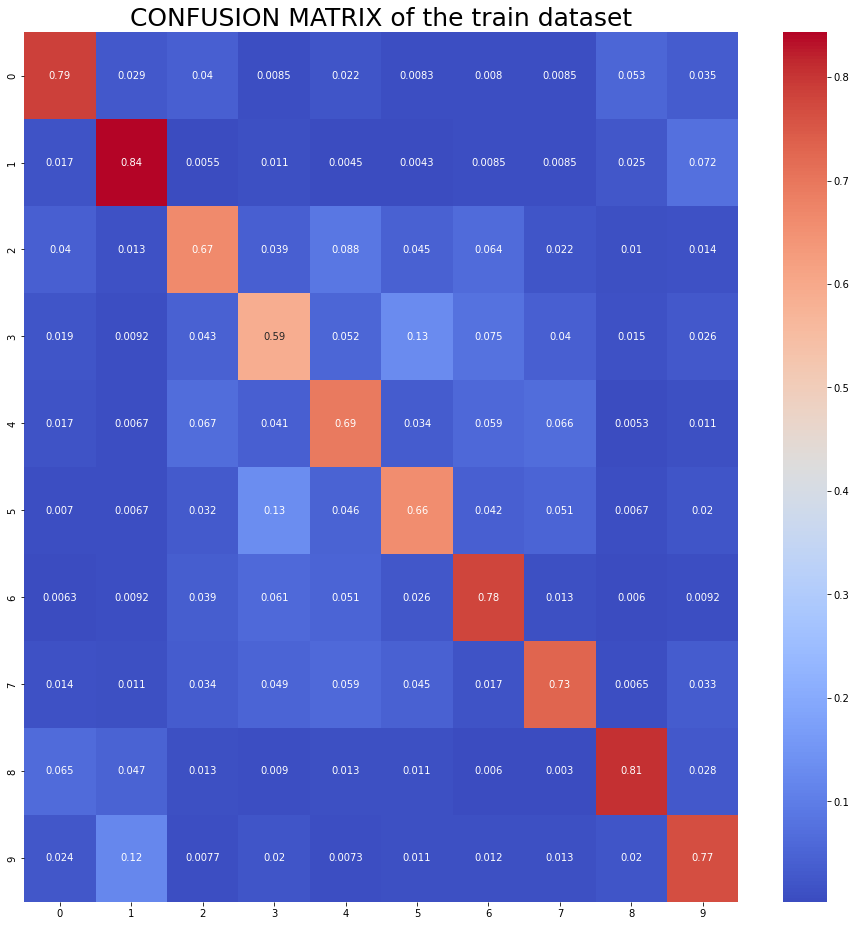

In [24]:
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(16, 16))
sns.heatmap(
    confusion_matrix(
        train_y_true,
        train_y_pred,
        normalize ='true'), 
        annot=True, cmap='coolwarm'
        )
plt.title("CONFUSION MATRIX of the train dataset", fontsize=25)
plt.show()

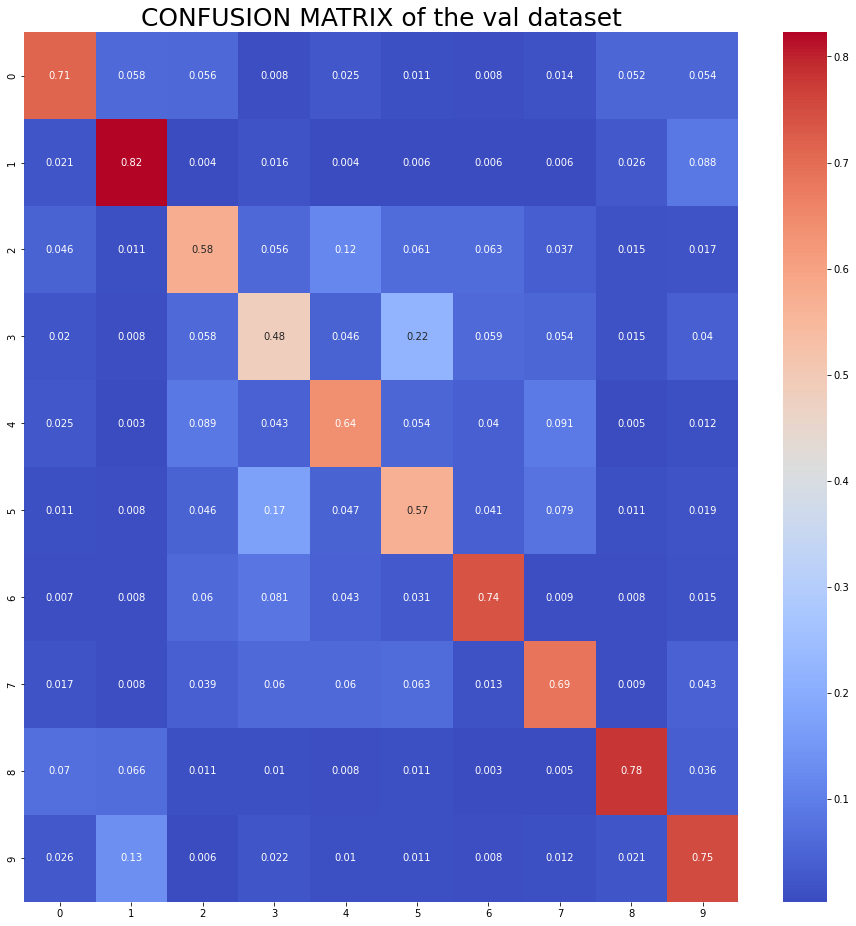

In [25]:
plt.figure(figsize=(16, 16))
sns.heatmap(
    confusion_matrix(
        val_y_true,
        val_y_pred,
        normalize = 'true'), 
        annot=True, cmap='coolwarm'
        )
plt.title("CONFUSION MATRIX of the val dataset", fontsize=25)
plt.show()

# 추론 

이제 학습이 완료되었습니다! 

그럼 test 데이터를 예측해 보아요.

test 데이터를 불어옵니다.

In [26]:
from glob import glob
import PIL.Image
import numpy as np

test_images = []

path = './data/'
for filename in sorted(glob(path + "test/*.jpg")):
    an_img = PIL.Image.open(filename) 
    img_array = np.array(an_img) 
    test_images.append(img_array) 

test_images = np.array(test_images)

In [27]:
class CustomDataset(Dataset):
    def __init__(self, transform):
        self.transform = transform 
        self.img_list = test_images
        self.img_labels = [0] * 10000 

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        return self.transform(image=self.img_list[idx]), self.img_labels[idx]

In [28]:
test_set = CustomDataset(transform=else_transform)

test_loader = DataLoader(test_set, batch_size = test_batch_size)

In [29]:
def test(model, loader, epoch, nb_epochs):

    model.eval()
    with torch.no_grad():
        for idx, batch in enumerate(loader):
            img = batch['img'].float().to(device)
            label = batch['label'].long().to(device)

            output = model(img)
            loss = criterion(output, label)

            # stats
            preds = torch.argmax(output, dim=1)

In [30]:
next(iter(test_loader))[0]['image'][0].shape

torch.Size([3, 64, 64])

본격적으로 test 데이터를 예측해보아요! 

예측을 할 때는 학습이 진행되지 않도록 net.eval() 코드를 작성해주어야 합니다. 

데이터가 backpropagation 되어 가중치가 수정되지 않도록 해주는 코드입니다. 

In [31]:
import pandas as pd
sample_submission = pd.read_csv('./data/sample_submission.csv')

model.eval()

batch_index = 0
with torch.no_grad():
    for i, (images, targets) in enumerate(test_loader):
        images = images['image'].to(device)
        outputs = model(images)
        batch_index = i * test_batch_size
        max_vals, max_indices = torch.max(outputs, 1)
        sample_submission.iloc[batch_index:batch_index + test_batch_size, 1:] = max_indices.long().cpu().numpy()[:,np.newaxis]

예측된 데이터의 라벨은 숫자로 되어있습니다. 

train 데이터를 불러올 때 ImageFolder 메소드를 사용해 데이터를 불러왔기 때문입니다. 

제출을 위해 라벨을 다시 복원 시켜 줍니다.

In [32]:
labels = {0:'airplane', 1:'automobile', 2:'bird', 3:'cat', 4:'deer',
          5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}
sample_submission['target'] = sample_submission['target'].map(labels)

In [33]:
sample_submission.head()

,id,target
0,0000.jpg,horse
1,0001.jpg,automobile
2,0002.jpg,truck
3,0003.jpg,dog
4,0004.jpg,airplane


In [34]:
sample_submission.to_csv(f'{np.max(val_acc_list):.4f}_'+f'{save_name}.csv', index=False)

축하합니다! 데이터 분석을 완료하셨습니다!

앞으로도 데이콘과 함께 즐겁게 데이터 분석 능력을 키워가시면 좋겠습니다.

감사합니다.